In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import json
import numpy as np
from torchvision import transforms

class CustomAgriculturalDataset(Dataset):
    """
    Custom dataset class for agricultural images with JSON annotations.
    Handles both detection and segmentation tasks from a single annotation file.
    
    Expected structure:
    dataset_root/
        ├── images/
        │   ├── image1.jpg
        │   ├── image2.jpg
        │   └── ...
        └── annotations.json
    """
    def __init__(self, dataset_root, transform=None):
        self.dataset_root = dataset_root
        self.transform = transform
        
        # Define paths
        self.image_dir = os.path.join(dataset_root, 'images')
        self.annotation_file = os.path.join(dataset_root, 'annotations.json')
        
        # Load annotations
        with open(self.annotation_file, 'r') as f:
            self.annotations = json.load(f)
            
        # Get list of all images
        self.image_files = sorted([f for f in os.listdir(self.image_dir) 
                                 if f.endswith(('.jpg', '.jpeg', '.png'))])
        
        # Create class mapping if not in annotations
        self.create_class_mapping()
        
    def create_class_mapping(self):
        """Create a mapping of class names to class IDs"""
        unique_classes = set()
        for ann in self.annotations['annotations']:
            if 'category' in ann:  # Adjust this based on your JSON structure
                unique_classes.add(ann['category'])
        
        self.class_to_id = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
        self.num_classes = len(self.class_to_id)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')
        
        # Get annotations for this image
        image_annotations = self.get_image_annotations(image_name)
        
        # Convert annotations to detection and segmentation formats
        detection_labels = self.convert_to_detection_format(
            image_annotations, 
            image.size
        )
        segmentation_mask = self.create_segmentation_mask(
            image_annotations,
            image.size
        )
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
            # Convert segmentation mask to tensor
            mask_transform = transforms.Compose([
                transforms.Resize(image.shape[-2:]),
                transforms.ToTensor()
            ])
            segmentation_mask = mask_transform(Image.fromarray(segmentation_mask))
        
        return image, detection_labels, segmentation_mask
    
    def get_image_annotations(self, image_name):
        """Extract annotations for a specific image"""
        # Adjust this based on your JSON structure
        image_anns = []
        for ann in self.annotations['annotations']:
            if ann['image_name'] == image_name:
                image_anns.append(ann)
        return image_anns
    
    def convert_to_detection_format(self, annotations, image_size):
        """Convert JSON annotations to detection format (class, x, y, w, h)"""
        detection_labels = []
        width, height = image_size
        
        for ann in annotations:
            # Adjust these fields based on your JSON structure
            if 'bbox' in ann:
                x, y, w, h = ann['bbox']
                class_id = self.class_to_id[ann['category']]
                
                # Normalize coordinates
                x_center = (x + w/2) / width
                y_center = (y + h/2) / height
                w = w / width
                h = h / height
                
                detection_labels.append([class_id, x_center, y_center, w, h])
        
        return torch.tensor(detection_labels)
    
    def create_segmentation_mask(self, annotations, image_size):
        """Create segmentation mask from JSON annotations"""
        width, height = image_size
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for ann in annotations:
            # Adjust these fields based on your JSON structure
            if 'segmentation' in ann:
                class_id = self.class_to_id[ann['category']]
                # Convert segmentation format based on your JSON structure
                # This example assumes polygon format
                polygon = np.array(ann['segmentation']).reshape(-1, 2)
                # Fill polygon with class ID
                from PIL import Image, ImageDraw
                img = Image.new('L', (width, height), 0)
                ImageDraw.Draw(img).polygon(polygon.flatten().tolist(), 
                                          outline=class_id, 
                                          fill=class_id)
                mask = np.maximum(mask, np.array(img))
        
        return mask

def create_data_loaders(dataset_root, train_split=0.8, batch_size=8, num_workers=4):
    """
    Create train and validation data loaders with automatic splitting
    """
    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create full dataset
    full_dataset = CustomAgriculturalDataset(
        dataset_root,
        transform=None  # We'll apply transforms after splitting
    )
    
    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    val_size = total_size - train_size
    
    # Split dataset
    train_dataset, val_dataset = random_split(
        full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Apply transforms to the splits
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader

# Example usage
def train_with_custom_dataset(model, dataset_root, num_epochs=100, batch_size=8):
    """
    Training function for custom dataset
    """
    # Create data loaders with automatic splitting
    train_loader, val_loader = create_data_loaders(
        dataset_root,
        train_split=0.8,
        batch_size=batch_size
    )
    
    # Rest of the training code remains the same...
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    detection_loss = nn.SmoothL1Loss()
    segmentation_loss = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (images, det_targets, seg_targets) in enumerate(train_loader):
            # Training step code...
            pass

if __name__ == "__main__":
    # Set your dataset path
    dataset_root = "/home/idrone2/Desktop/new"  # Replace with your actual path
    
    # Create and train model
    model = UnifiedAgriVisionSegmentation(num_classes=6)  # Adjust based on your classes
    train_with_custom_dataset(model, dataset_root)

NameError: name 'UnifiedAgriVisionSegmentation' is not defined

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import json
import numpy as np
from torchvision import transforms

# First, let's define our main model architecture
class UnifiedAgriVisionSegmentation(nn.Module):
    """
    A unified deep learning model for agricultural vision tasks,
    combining object detection and segmentation capabilities.
    """
    def __init__(self, num_classes, input_size=512):
        super(UnifiedAgriVisionSegmentation, self).__init__()
        
        # Feature extraction backbone
        self.backbone = nn.Sequential(
            # Initial convolution block
            self._create_conv_block(3, 64),
            self._create_conv_block(64, 128),
            self._create_conv_block(128, 256),
            self._create_conv_block(256, 512)
        )
        
        # Object detection branch
        self.detection_head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes * 5, 1)  # 5 values per class (x, y, w, h, conf)
        )
        
        # Segmentation branch
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, 1)
        )
    
    def _create_conv_block(self, in_channels, out_channels):
        """Helper method to create a convolution block with batch norm and ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    
    def forward(self, x):
        # Extract features through backbone
        features = self.backbone(x)
        
        # Generate detection and segmentation outputs
        detection = self.detection_head(features)
        segmentation = self.segmentation_head(features)
        
        # Resize segmentation output to input size
        segmentation = F.interpolate(
            segmentation, 
            size=x.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )
        
        return detection, segmentation

# [Previous CustomAgriculturalDataset code remains the same]

def create_data_loaders(dataset_root, train_split=0.8, batch_size=8, num_workers=4):
    """Create train and validation data loaders with automatic splitting"""
    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset
    full_dataset = CustomAgriculturalDataset(dataset_root, transform=None)
    
    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    val_size = total_size - train_size
    
    # Split dataset
    train_dataset, val_dataset = random_split(
        full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Apply transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader

def train_model(model, dataset_root, num_epochs=100, batch_size=8):
    """Main training function"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create data loaders
    train_loader, val_loader = create_data_loaders(
        dataset_root,
        batch_size=batch_size
    )
    
    # Initialize optimizer and losses
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    detection_loss = nn.SmoothL1Loss()
    segmentation_loss = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, (images, det_targets, seg_targets) in enumerate(train_loader):
            # Move data to device
            images = images.to(device)
            det_targets = det_targets.to(device)
            seg_targets = seg_targets.to(device)
            
            # Forward pass
            det_output, seg_output = model(images)
            
            # Calculate losses
            det_loss = detection_loss(det_output, det_targets)
            seg_loss = segmentation_loss(seg_output, seg_targets)
            loss = det_loss + seg_loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Print progress
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        # Print epoch summary
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch} completed. Average Loss: {avg_loss:.4f}')

# Example usage
if __name__ == "__main__":
    # Set your dataset path
    dataset_root = "/home/idrone2/Desktop/new"  # Replace with your actual path
    
    # Create model
    model = UnifiedAgriVisionSegmentation(num_classes=6)  # Adjust based on your number of classes
    
    # Train model
    train_model(model, dataset_root)

KeyError: 'annotations'

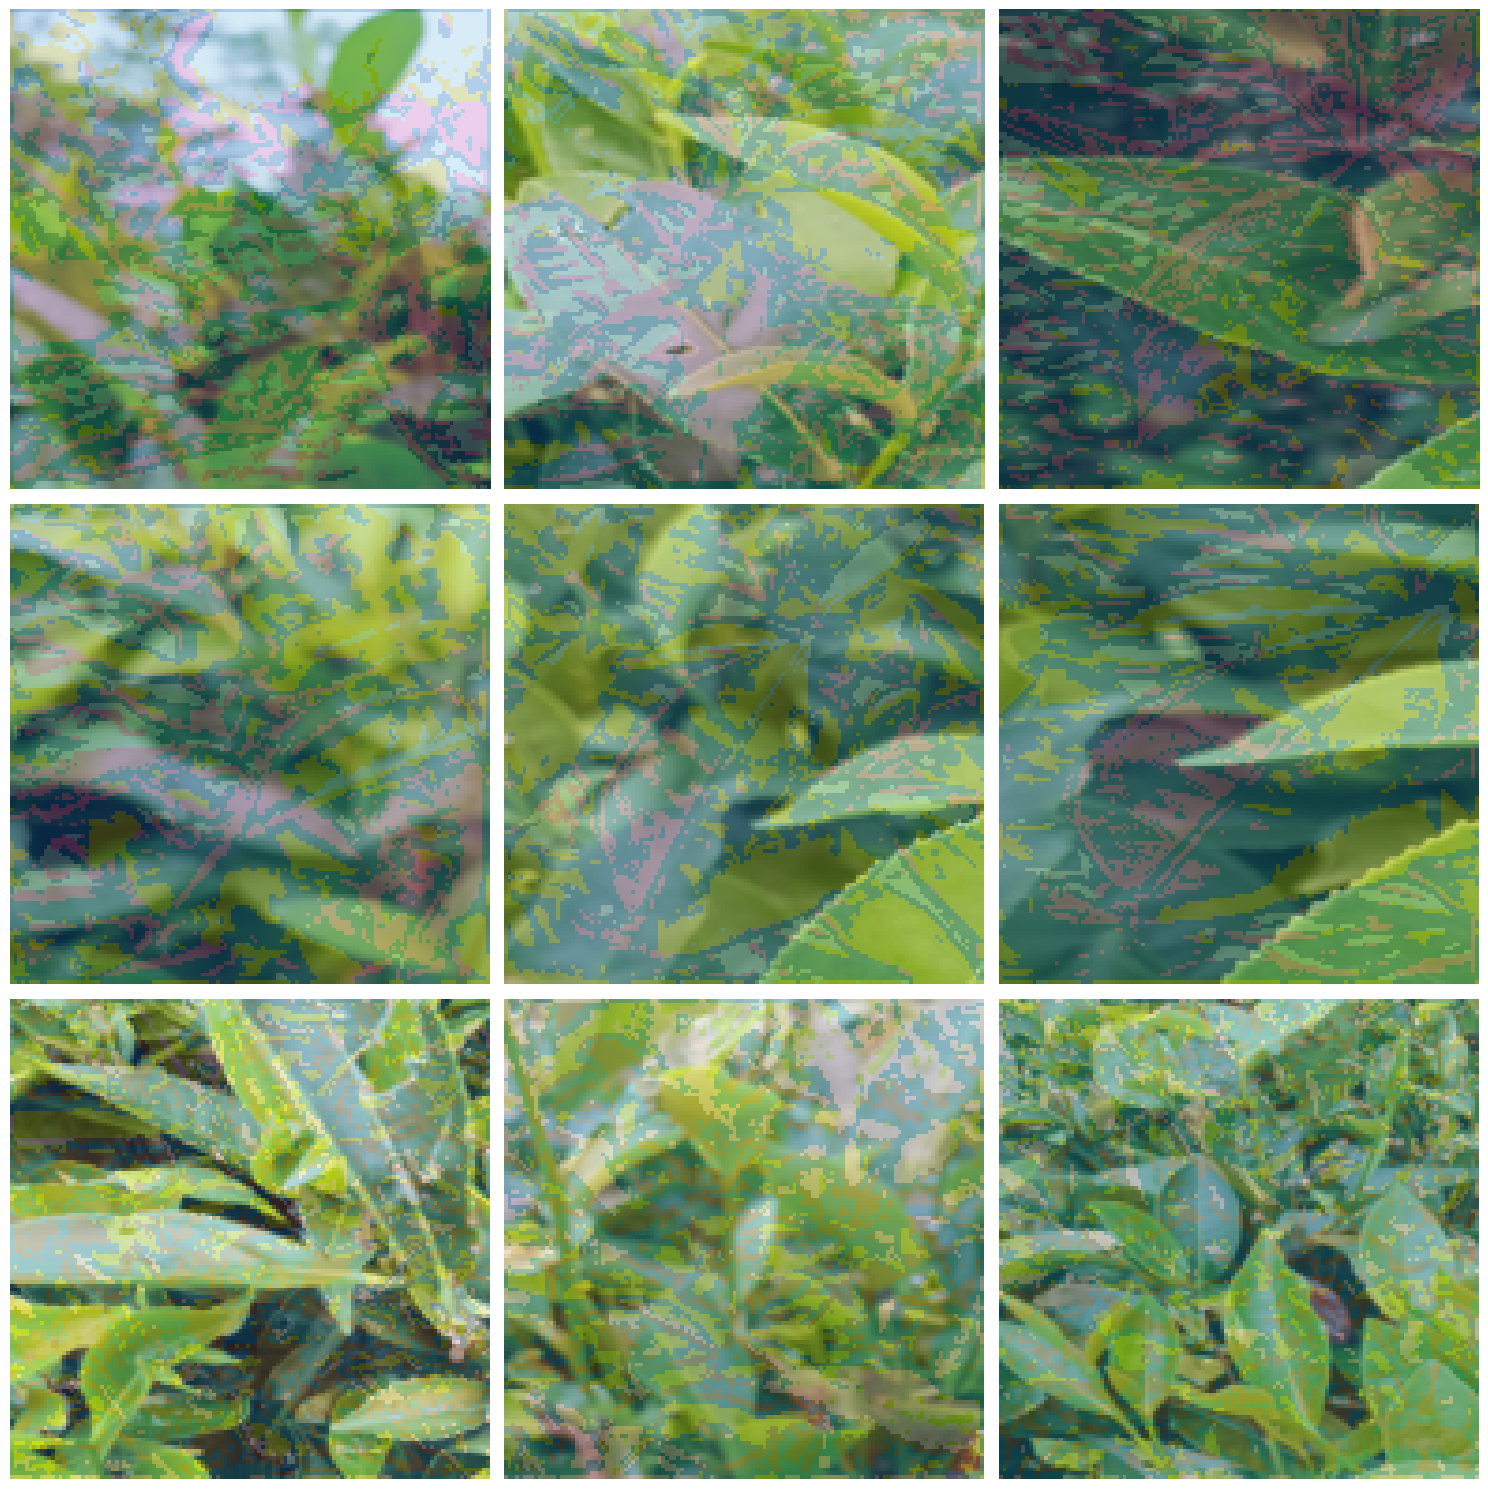

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random

class CustomAgriculturalDataset(Dataset):
    """
    Modified dataset class to handle specific JSON annotation format
    and image structure.
    """
    def __init__(self, dataset_root, transform=None):
        self.dataset_root = dataset_root
        self.transform = transform

        # Define paths
        self.image_dir = os.path.join(dataset_root, 'images')
        self.annotation_file = os.path.join(dataset_root, 'annotations.json')

        # Load annotations
        if os.path.exists(self.annotation_file):
            with open(self.annotation_file, 'r') as f:
                self.annotations = json.load(f)
        else:
            self.annotations = {}

        # Get list of all images
        self.image_files = sorted([
            f for f in os.listdir(self.image_dir)
            if f.endswith(('.jpg', '.jpeg', '.png'))
        ])

        # Create class mapping
        self.create_class_mapping()

    def create_class_mapping(self):
        """Create a mapping of class names to class IDs based on JSON structure"""
        unique_classes = set()

        if isinstance(self.annotations, dict):
            for img_name, ann in self.annotations.items():
                class_name = ann.get('class') or ann.get('category')
                if class_name:
                    unique_classes.add(class_name)

        if not unique_classes:
            unique_classes = {'background', 'object'}

        self.class_to_id = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
        self.id_to_class = {idx: cls for cls, idx in self.class_to_id.items()}
        self.num_classes = len(self.class_to_id)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')

        image_annotations = self.get_image_annotations(image_name)

        detection_labels = self.convert_to_detection_format(
            image_annotations,
            image.size
        )
        segmentation_mask = self.create_segmentation_mask(
            image_annotations,
            image.size
        )

        if self.transform:
            image = self.transform(image)
            segmentation_mask = torch.tensor(segmentation_mask, dtype=torch.long)

        return image, detection_labels, segmentation_mask

    def get_image_annotations(self, image_name):
        return self.annotations.get(image_name, {})

    def convert_to_detection_format(self, annotations, image_size):
        detection_labels = []
        width, height = image_size

        if 'bbox' in annotations:
            bbox = annotations['bbox']
            class_id = self.class_to_id.get(
                annotations.get('class', 'object'),
                0
            )

            x, y, w, h = bbox
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            w /= width
            h /= height

            detection_labels.append([class_id, 1.0, x_center, y_center, w, h])

        return torch.tensor(detection_labels)

    def create_segmentation_mask(self, annotations, image_size):
        width, height = image_size
        mask = np.zeros((height, width), dtype=np.uint8)

        if 'segmentation' in annotations:
            class_id = self.class_to_id.get(
                annotations.get('class', 'object'),
                0
            )
            segmentation = annotations['segmentation']
            mask = np.array(segmentation).astype(np.uint8)

        return mask


class UnifiedAgriVisionSegmentation(nn.Module):
    """
    A simple model for combined object detection and segmentation.
    """
    def __init__(self, num_classes):
        super(UnifiedAgriVisionSegmentation, self).__init__()
        
        # Backbone
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Detection head
        self.det_conv = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Dynamically calculate the size for the fully connected layer
        self._initialize_fc_layer(num_classes)
        
        # Segmentation head
        self.seg_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.seg_conv2 = nn.Conv2d(128, num_classes, kernel_size=1)

    def _initialize_fc_layer(self, num_classes):
        """Dynamically compute the size of the fully connected layer input."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 256, 256)  # Assuming 256x256 input images
            x = F.relu(self.conv1(dummy_input))
            x = self.pool(F.relu(self.conv2(x)))
            det_x = F.relu(self.det_conv(x))
            flattened_size = det_x.view(1, -1).size(1)
        
        self.det_fc = nn.Linear(flattened_size, num_classes * 6)  # 6 for [class_id, conf, x, y, w, h]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        # Detection branch
        det_x = F.relu(self.det_conv(x))
        det_x = det_x.view(det_x.size(0), -1)
        det_out = self.det_fc(det_x)
        det_out = det_out.view(-1, 1, 6)

        # Segmentation branch
        seg_x = F.relu(self.seg_conv1(x))
        seg_out = self.seg_conv2(seg_x)

        return det_out, seg_out


def visualize_predictions(model, dataset, device, num_images=9):
    model.eval()
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx, ax_idx in enumerate(np.ndindex(3, 3)):
            if idx >= num_images:
                break

            image, det_labels, seg_mask = dataset[indices[idx]]
            input_image = image.unsqueeze(0).to(device)

            det_pred, seg_pred = model(input_image)
            seg_pred = torch.argmax(seg_pred.squeeze(), dim=0).cpu()

            ax = axes[ax_idx[0]][ax_idx[1]]
            img_np = image.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            ax.imshow(img_np)

            # Plot detection boxes with labels
            for box in det_pred[0]:
                if len(box) >= 6:
                    class_id, conf, x, y, w, h = box[:6]
                    if conf > 0.5:
                        img_width, img_height = img_np.shape[1], img_np.shape[0]
                        x_pixel = (x - w / 2) * img_width
                        y_pixel = (y - h / 2) * img_height
                        w_pixel = w * img_width
                        h_pixel = h * img_height

                        rect = plt.Rectangle(
                            (x_pixel, y_pixel),
                            w_pixel, h_pixel,
                            fill=False,
                            color='red',
                            linewidth=2
                        )
                        ax.add_patch(rect)

                        class_name = dataset.id_to_class.get(int(class_id), 'Unknown')
                        ax.text(x_pixel, y_pixel - 5, f'{class_name} ({conf:.2f})',
                                color='yellow', fontsize=12, backgroundcolor='black')

            ax.imshow(seg_pred.numpy(), alpha=0.3, cmap='tab20')
            ax.axis('off')

    plt.tight_layout()
    plt.show()


# Training function with visualization
def train_and_visualize(model, dataset_root, num_epochs=10, batch_size=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = CustomAgriculturalDataset(dataset_root, transform=val_transform)
    visualize_predictions(model, dataset, device)


if __name__ == "__main__":
    dataset_root = " /home/idrone2/Desktop/new"  # Replace with your path
    model = UnifiedAgriVisionSegmentation(num_classes=7)  # Adjusted for 7 classes
    train_and_visualize(model, dataset_root)

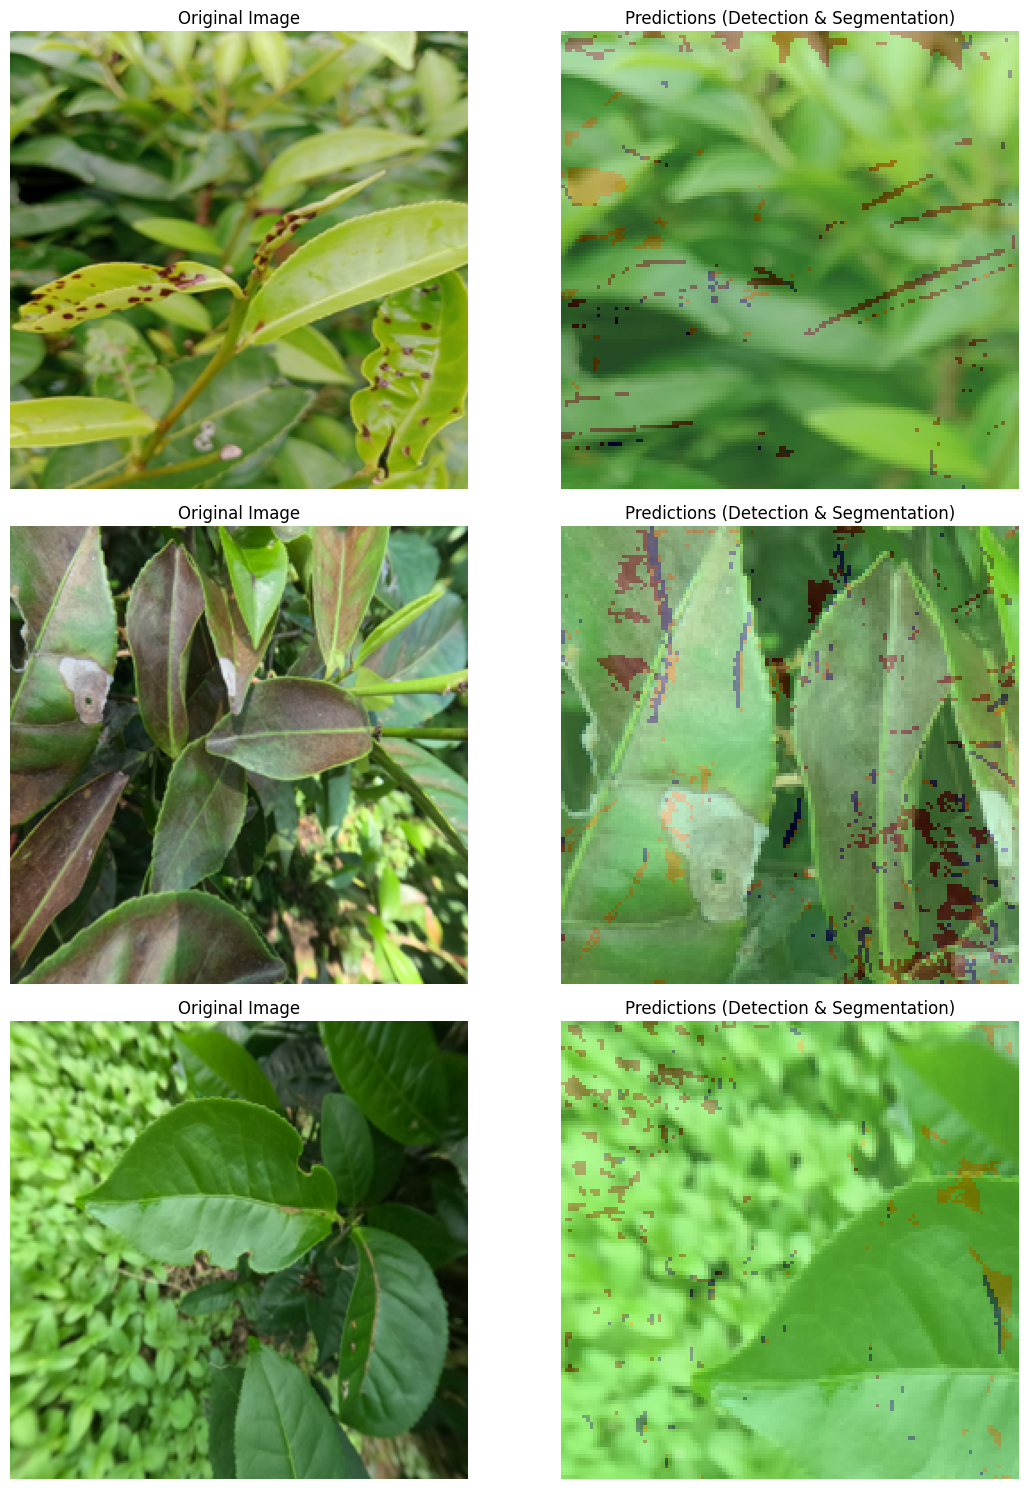

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random

###############################################################################
# 1. DATASET DEFINITION
###############################################################################

class CustomAgriculturalDataset(Dataset):
    """
    Dataset class that handles images and JSON annotations.
    The annotations are expected to contain 'bbox', 'segmentation', and a class key ('class' or 'category').
    """
    def __init__(self, dataset_root, transform=None):
        self.dataset_root = dataset_root
        self.transform = transform

        # Define paths.
        self.image_dir = os.path.join(dataset_root, 'images')
        self.annotation_file = os.path.join(dataset_root, 'annotations.json')

        # Load annotations.
        if os.path.exists(self.annotation_file):
            with open(self.annotation_file, 'r') as f:
                self.annotations = json.load(f)
        else:
            self.annotations = {}

        # Get list of image files.
        self.image_files = sorted([
            f for f in os.listdir(self.image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        # Create a class mapping.
        self.create_class_mapping()

    def create_class_mapping(self):
        """Creates a mapping from class names to numerical IDs based on the annotations."""
        unique_classes = set()
        if isinstance(self.annotations, dict):
            for img_name, ann in self.annotations.items():
                cls_name = ann.get('class') or ann.get('category')
                if cls_name:
                    unique_classes.add(cls_name)
        if not unique_classes:
            unique_classes = {'background', 'object'}
        self.class_to_id = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
        self.id_to_class = {idx: cls for cls, idx in self.class_to_id.items()}
        self.num_classes = len(self.class_to_id)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')
        image_annotations = self.annotations.get(image_name, {})

        # Convert bbox annotation to detection format: [class_id, conf, x_center, y_center, w, h]
        detection_labels = self.convert_to_detection_format(image_annotations, image.size)
        # Get segmentation mask (if provided).
        segmentation_mask = self.create_segmentation_mask(image_annotations, image.size)

        if self.transform:
            image = self.transform(image)
            segmentation_mask = torch.tensor(segmentation_mask, dtype=torch.long)

        return image, detection_labels, segmentation_mask

    def convert_to_detection_format(self, annotations, image_size):
        """Converts the bbox (if any) to a normalized format."""
        detection_labels = []
        width, height = image_size

        if 'bbox' in annotations:
            bbox = annotations['bbox']  # Expecting [x, y, w, h]
            class_id = self.class_to_id.get(annotations.get('class', 'object'), 0)
            x, y, w, h = bbox
            # Convert to center coordinates and normalize.
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            w_norm = w / width
            h_norm = h / height
            # Add a dummy confidence score.
            detection_labels.append([class_id, 1.0, x_center, y_center, w_norm, h_norm])

        return torch.tensor(detection_labels)

    def create_segmentation_mask(self, annotations, image_size):
        """Creates a segmentation mask from annotations (if provided). Otherwise, returns an empty mask."""
        width, height = image_size
        mask = np.zeros((height, width), dtype=np.uint8)
        if 'segmentation' in annotations:
            # This example assumes that the segmentation is provided as a mask array.
            mask = np.array(annotations['segmentation']).astype(np.uint8)
        return mask

###############################################################################
# 2. MODEL DEFINITION
###############################################################################

class UnifiedAgriVisionSegmentation(nn.Module):
    """
    A simple CNN model with two heads: one for object detection and one for segmentation.
    """
    def __init__(self, num_classes):
        super(UnifiedAgriVisionSegmentation, self).__init__()
        
        # Backbone.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Detection head.
        self.det_conv = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self._initialize_fc_layer(num_classes)
        
        # Segmentation head.
        self.seg_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.seg_conv2 = nn.Conv2d(128, num_classes, kernel_size=1)

    def _initialize_fc_layer(self, num_classes):
        """Dynamically compute the size for the fully connected layer used for detection."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 256, 256)  # assuming 256x256 images
            x = F.relu(self.conv1(dummy_input))
            x = self.pool(F.relu(self.conv2(x)))
            det_x = F.relu(self.det_conv(x))
            flattened_size = det_x.view(1, -1).size(1)
        # The detection head outputs 6 values per box: [class_id, conf, x_center, y_center, w, h]
        self.det_fc = nn.Linear(flattened_size, num_classes * 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        # Detection branch.
        det_x = F.relu(self.det_conv(x))
        det_x = det_x.view(det_x.size(0), -1)
        det_out = self.det_fc(det_x)
        # Reshape to (num_detections, 1, 6)
        det_out = det_out.view(-1, 1, 6)

        # Segmentation branch.
        seg_x = F.relu(self.seg_conv1(x))
        seg_out = self.seg_conv2(seg_x)

        return det_out, seg_out

###############################################################################
# 3. VISUALIZATION (LIKE MASK RCNN / YOLO)
###############################################################################

def visualize_predictions(model, dataset, device, indices=None, conf_threshold=0.5):
    """
    Displays a side-by-side comparison:
      - Left: Original image.
      - Right: Predicted image with detection boxes (class & confidence) and segmentation mask.
    The appearance is intended to resemble outputs from models like Mask RCNN or YOLO.
    """
    model.eval()
    
    # If no indices provided, select 3 random images.
    if indices is None:
        indices = random.sample(range(len(dataset)), 3)
    
    n = len(indices)
    fig, axs = plt.subplots(n, 2, figsize=(12, 5 * n))
    if n == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i, idx in enumerate(indices):
        # Load the original image (for display) without normalization.
        image_name = dataset.image_files[idx]
        image_path = os.path.join(dataset.image_dir, image_name)
        original_image = Image.open(image_path).convert("RGB")
        original_image = original_image.resize((256, 256))
        original_np = np.array(original_image) / 255.0

        # Get transformed image for the model.
        image, _, _ = dataset[idx]
        input_image = image.unsqueeze(0).to(device)

        # Get model predictions.
        with torch.no_grad():
            det_pred, seg_pred = model(input_image)
        # Process segmentation: take argmax across channels.
        seg_pred = torch.argmax(seg_pred.squeeze(), dim=0).cpu().numpy()

        # Process detection predictions.
        # Expected shape: (num_boxes, 1, 6); here we iterate over each predicted box.
        det_boxes = det_pred[0].cpu().numpy()  # shape: (num_boxes, 6)

        # -------------------------
        # Left: Original Image.
        # -------------------------
        axs[i, 0].imshow(original_np)
        axs[i, 0].set_title("Original Image")
        axs[i, 0].axis("off")

        # -------------------------
        # Right: Predicted Image.
        # -------------------------
        axs[i, 1].imshow(original_np)
        img_h, img_w, _ = original_np.shape
        for box in det_boxes:
            if len(box) < 6:
                continue
            class_id, conf, x_center, y_center, w, h = box
            if conf < conf_threshold:
                continue

            # Convert normalized coordinates to pixel values.
            box_w = w * img_w
            box_h = h * img_h
            x_pixel = (x_center * img_w) - (box_w / 2)
            y_pixel = (y_center * img_h) - (box_h / 2)

            # Draw rectangle.
            rect = plt.Rectangle((x_pixel, y_pixel), box_w, box_h,
                                 fill=False, edgecolor="red", linewidth=2)
            axs[i, 1].add_patch(rect)
            class_name = dataset.id_to_class.get(int(class_id), "Unknown")
            axs[i, 1].text(x_pixel, y_pixel - 5, f"{class_name} ({conf:.2f})",
                           color="yellow", fontsize=12,
                           bbox=dict(facecolor="red", alpha=0.5))
        
        # Overlay segmentation mask with transparency.
        axs[i, 1].imshow(seg_pred, alpha=0.3, cmap="jet")
        axs[i, 1].set_title("Predictions (Detection & Segmentation)")
        axs[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

###############################################################################
# 4. MAIN FUNCTION
###############################################################################

def main():
    # Update this to your dataset root.
    dataset_root = "/home/idrone2/Desktop/new"  # Make sure the path is correct.
    num_classes = 7  # Adjust number of classes as needed.

    # Define transformation: resize, convert to tensor, and normalize.
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Initialize dataset and model.
    dataset = CustomAgriculturalDataset(dataset_root, transform=transform)
    model = UnifiedAgriVisionSegmentation(num_classes=num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Visualize predictions.
    visualize_predictions(model, dataset, device, conf_threshold=0.5)

if __name__ == "__main__":
    main()


CUDA out of memory, switching to CPU for this image.


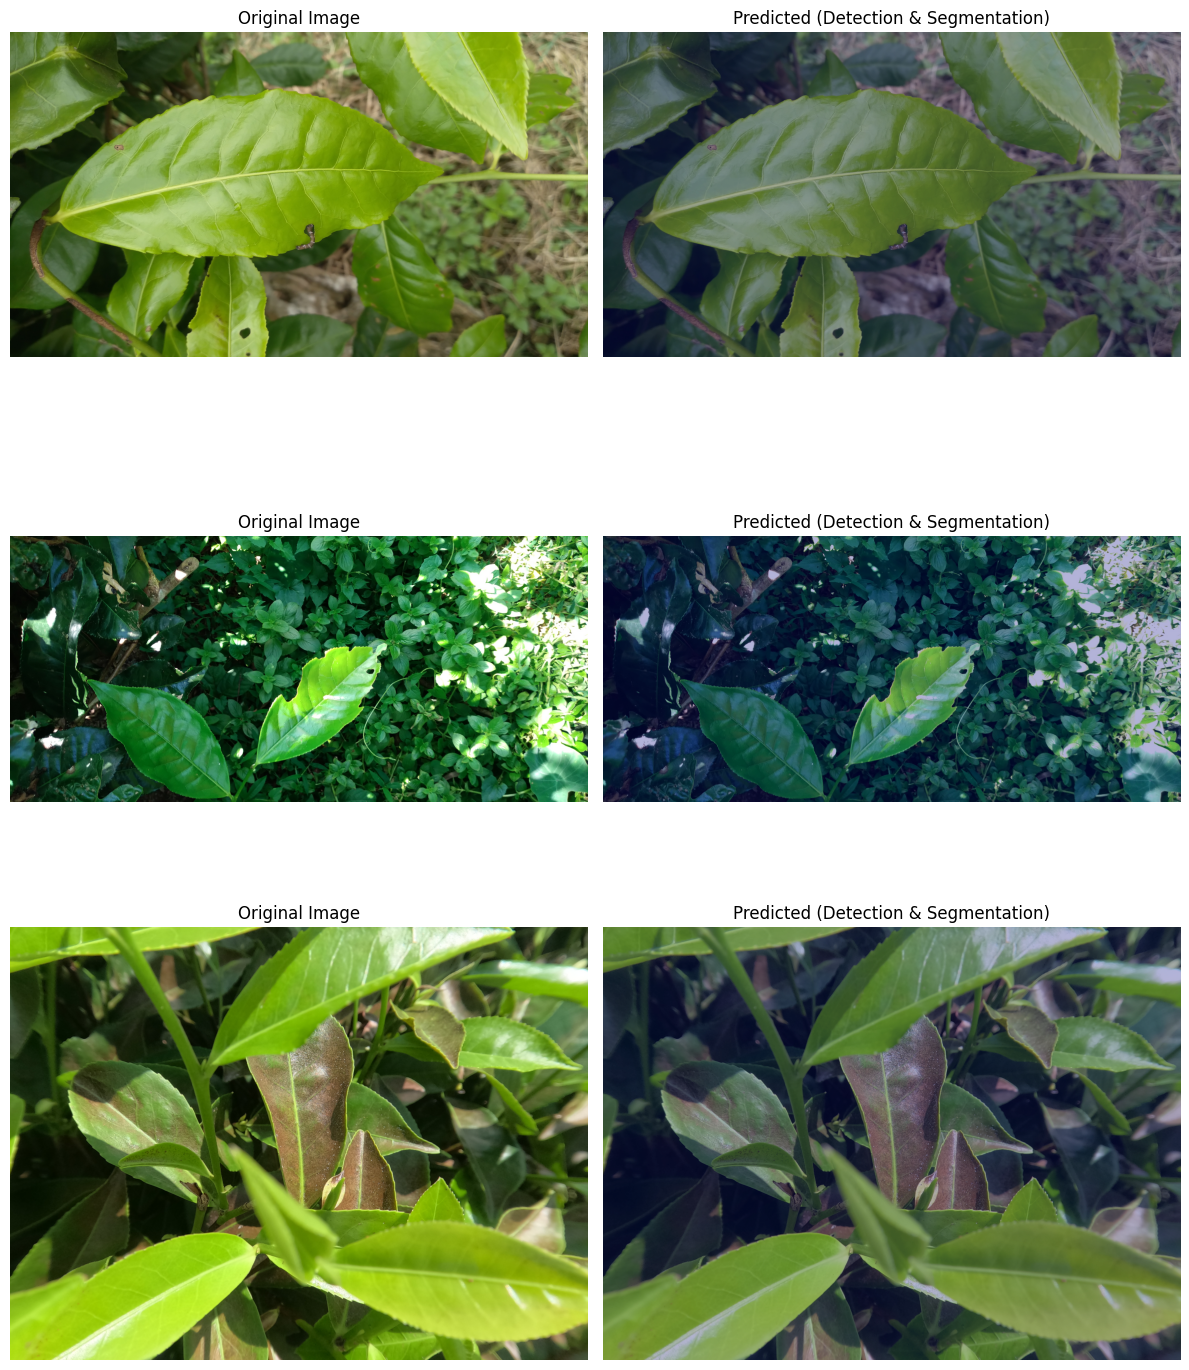

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision.transforms import ToTensor

###############################################################################
# 1. DATASET CLASS (USING ORIGINAL IMAGE SIZE)
###############################################################################

class CustomAgriculturalDataset(Dataset):
    """
    Loads images and annotations without resizing. The images are kept at their
    original resolution.
    """
    def __init__(self, dataset_root):
        self.dataset_root = dataset_root
        self.image_dir = os.path.join(dataset_root, 'images')
        self.annotation_file = os.path.join(dataset_root, 'annotations.json')

        if os.path.exists(self.annotation_file):
            with open(self.annotation_file, 'r') as f:
                self.annotations = json.load(f)
        else:
            self.annotations = {}

        self.image_files = sorted([
            f for f in os.listdir(self.image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        self.create_class_mapping()

    def create_class_mapping(self):
        unique_classes = set()
        for img_name, ann in self.annotations.items():
            cls_name = ann.get('class') or ann.get('category')
            if cls_name:
                unique_classes.add(cls_name)
        if not unique_classes:
            unique_classes = {'background', 'object'}
        self.class_to_id = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
        self.id_to_class = {idx: cls for cls, idx in self.class_to_id.items()}
        self.num_classes = len(self.class_to_id)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')
        image_annotations = self.annotations.get(image_name, {})

        # Convert bounding box annotation to detection format: [class_id, conf, x_center, y_center, w, h]
        detection_labels = self.convert_to_detection_format(image_annotations, image.size)
        # Create segmentation mask (if available); otherwise, return an empty mask.
        segmentation_mask = self.create_segmentation_mask(image_annotations, image.size)

        # Convert the image to a tensor (pixel values scaled to [0, 1]) without resizing.
        image_tensor = ToTensor()(image)

        return image_tensor, detection_labels, segmentation_mask

    def convert_to_detection_format(self, annotations, image_size):
        detection_labels = []
        width, height = image_size

        if 'bbox' in annotations:
            bbox = annotations['bbox']  # Expected format: [x, y, w, h]
            class_id = self.class_to_id.get(annotations.get('class', 'object'), 0)
            x, y, w, h = bbox
            # Convert to normalized center coordinates and dimensions.
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            w_norm = w / width
            h_norm = h / height

            # A dummy confidence of 1.0 is used here.
            detection_labels.append([class_id, 1.0, x_center, y_center, w_norm, h_norm])

        return torch.tensor(detection_labels)

    def create_segmentation_mask(self, annotations, image_size):
        width, height = image_size
        mask = np.zeros((height, width), dtype=np.uint8)
        if 'segmentation' in annotations:
            mask = np.array(annotations['segmentation']).astype(np.uint8)
        return mask

###############################################################################
# 2. MODEL DEFINITION (WITH ADAPTIVE POOLING FOR VARIABLE INPUT SIZE)
###############################################################################

class UnifiedAgriVisionSegmentation(nn.Module):
    """
    A simple CNN with two heads:
      - A detection head that outputs normalized bounding boxes as
        [class_id, confidence, x_center, y_center, width, height].
      - A segmentation head that produces a per-pixel prediction.
    Adaptive pooling is used in the detection branch so that the network can
    process images of arbitrary size.
    """
    def __init__(self, num_classes, pooling_size=(8, 8)):
        super(UnifiedAgriVisionSegmentation, self).__init__()
        # Shared backbone.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Detection branch.
        self.det_conv = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pooling_size = pooling_size
        flattened_size = 128 * pooling_size[0] * pooling_size[1]
        self.det_fc = nn.Linear(flattened_size, num_classes * 6)  # 6 values per detection.

        # Segmentation branch.
        self.seg_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.seg_conv2 = nn.Conv2d(128, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        # Detection branch.
        det_x = F.relu(self.det_conv(x))
        det_x = F.adaptive_avg_pool2d(det_x, self.pooling_size)
        det_x = det_x.view(det_x.size(0), -1)
        det_out = self.det_fc(det_x)
        det_out = det_out.view(-1, 1, 6)

        # Segmentation branch.
        seg_x = F.relu(self.seg_conv1(x))
        seg_out = self.seg_conv2(seg_x)

        return det_out, seg_out

###############################################################################
# 3. VISUALIZATION FUNCTION WITH CPU FALLBACK & CLASS LABELS/CONFIDENCE
###############################################################################

def visualize_predictions(model, dataset, device, indices=None, conf_threshold=0.5):
    """
    For each selected image, this function displays:
      - Left panel: The original image.
      - Right panel: The predicted image with:
          - Detection bounding boxes (each annotated with class name and confidence).
          - A summary (aggregated predicted class names and confidence scores) at the top.
          - A semi-transparent segmentation mask overlay.
    If a CUDA out-of-memory error is encountered, inference is retried on CPU.
    """
    model.eval()
    if indices is None:
        indices = random.sample(range(len(dataset)), 3)
    n = len(indices)
    fig, axs = plt.subplots(n, 2, figsize=(12, 5 * n))
    if n == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i, idx in enumerate(indices):
        # Load the original image (without any resizing).
        image_name = dataset.image_files[idx]
        image_path = os.path.join(dataset.image_dir, image_name)
        original_image = Image.open(image_path).convert("RGB")
        original_np = np.array(original_image) / 255.0  # For display.

        # Get the tensor from the dataset.
        image_tensor, _, _ = dataset[idx]
        input_image = image_tensor.unsqueeze(0).to(device)

        # Attempt to run the model. If CUDA OOM is encountered, switch to CPU.
        try:
            with torch.no_grad():
                det_pred, seg_pred = model(input_image)
        except RuntimeError as e:
            if "out of memory" in str(e):
                print("CUDA out of memory, switching to CPU for this image.")
                torch.cuda.empty_cache()
                device_cpu = torch.device("cpu")
                model = model.to(device_cpu)
                input_image = input_image.to(device_cpu)
                with torch.no_grad():
                    det_pred, seg_pred = model(input_image)
                device = device_cpu
            else:
                raise e

        # If on GPU, free cached memory.
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Process segmentation output: upscale (nearest neighbor) to the original image size.
        seg_pred = torch.argmax(seg_pred.squeeze(), dim=0).cpu().numpy()
        seg_pred_img = Image.fromarray(seg_pred.astype(np.uint8))
        seg_pred_resized = np.array(seg_pred_img.resize(original_image.size, resample=Image.NEAREST))

        # Process detection predictions.
        # Expected format for each box: [class_id, conf, x_center, y_center, w, h] (all normalized).
        det_boxes = det_pred[0].cpu().numpy()

        # Left panel: Original image.
        axs[i, 0].imshow(original_np)
        axs[i, 0].set_title("Original Image")
        axs[i, 0].axis("off")

        # Right panel: Overlay predictions on the original image.
        axs[i, 1].imshow(original_np)
        img_h, img_w, _ = original_np.shape

        prediction_summary = []  # Collect predictions for summary text.
        for box in det_boxes:
            if len(box) < 6:
                continue
            class_id, conf, x_center, y_center, w_norm, h_norm = box
            if conf < conf_threshold:
                continue

            # Convert normalized coordinates to pixel coordinates.
            box_w = w_norm * img_w
            box_h = h_norm * img_h
            x_pixel = (x_center * img_w) - (box_w / 2)
            y_pixel = (y_center * img_h) - (box_h / 2)

            # Draw the bounding box.
            rect = plt.Rectangle((x_pixel, y_pixel), box_w, box_h,
                                 fill=False, edgecolor="red", linewidth=2)
            axs[i, 1].add_patch(rect)
            class_name = dataset.id_to_class.get(int(class_id), "Unknown")
            # Annotate each box with the class name and confidence.
            axs[i, 1].text(x_pixel, y_pixel - 5, f"{class_name} ({conf:.2f})",
                           color="yellow", fontsize=12,
                           bbox=dict(facecolor="red", alpha=0.5))
            prediction_summary.append(f"{class_name}: {conf:.2f}")

        # Add a summary text (aggregated predictions) at the top-left corner.
        if prediction_summary:
            summary_text = ", ".join(prediction_summary)
            axs[i, 1].text(10, 20, summary_text, fontsize=12, color="white",
                           bbox=dict(facecolor="black", alpha=0.7))

        # Overlay the segmentation mask.
        axs[i, 1].imshow(seg_pred_resized, alpha=0.3, cmap="jet")
        axs[i, 1].set_title("Predicted (Detection & Segmentation)")
        axs[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

###############################################################################
# 4. MAIN FUNCTION
###############################################################################

def main():
    # Update this path to your dataset root (containing an "images" folder and "annotations.json").
    dataset_root = "/home/idrone2/Desktop/new"  
    num_classes = 7  # Adjust this based on your annotation classes.
    
    # Create the dataset (images are loaded at original size).
    dataset = CustomAgriculturalDataset(dataset_root)
    
    # Initialize the model.
    model = UnifiedAgriVisionSegmentation(num_classes=num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Visualize predictions (the script will switch to CPU if a CUDA OOM error occurs).
    visualize_predictions(model, dataset, device, conf_threshold=0.5)

if __name__ == "__main__":
    main()
